This demo is adapted from Prof. David Inouye. 
Prof. Wang updated the last part to illustrate caveats of K-means algorithm.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Consider a small "city" of people.

- Each point represents a person
- Friendships are formed entirely based on how close they live to each other  

Could you put these people into communities?

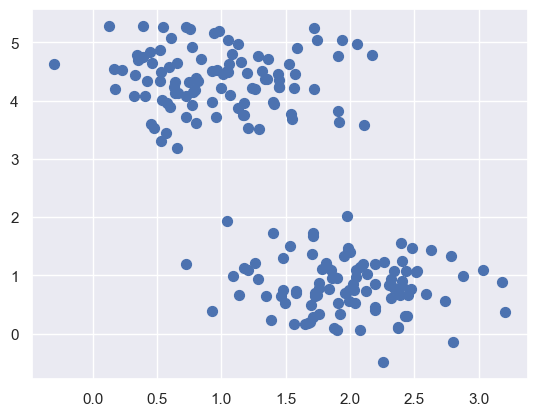

In [97]:
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=200, centers=2,
                       cluster_std=0.50, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

# How do we formalize what we did visually?

- Let's assume for now that we know there are exactly *two* communities
- How can we assign each person to a community?
- Naive idea: Randomly assign points to each community

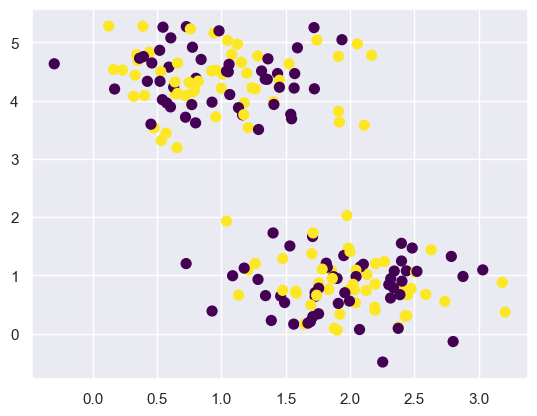

In [98]:
from sklearn.utils import check_random_state
def get_random_assignment(random_state=None):
    rng = check_random_state(random_state)
    y = rng.randint(2, size=X.shape[0])
    return y
y_rand = get_random_assignment(random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y_rand, s=50, cmap='viridis')

# This clustering "looks" quite bad.
# How can we formalize whether a particular assignment is good or bad?

- One intuition: People in a communities will be as close to each other as possible.
- Take average distance between each person in a community to every other person in the **same** community.
- Sum over all communities.

# Implement objective via vectorized calls

$$\mathcal{C}_j = \{ x \in \mathcal{X}: y = j \}$$
$$\sum_{j=1}^k \frac{1}{2|\mathcal{C}_j|} \sum_{x \in \mathcal{C}_j, z \in \mathcal{C}_j} \text{dist}(x, z)^2$$

In [99]:
from sklearn.metrics import pairwise_distances
# Using vectorized and list comprehensions computation
def objective(X, y):
    y_vals = np.unique(y)
    def inner(yv):
        sel = (y==yv)  # boolean array
        Xj = X[sel, :]
        n_community = np.sum(sel)
        community_sum = np.sum(pairwise_distances(Xj, Xj)**2)
        return community_sum / (2*n_community)
    return np.sum([inner(yv) for yv in y_vals])

print(objective(X, y_rand))

767.2572924351311


# Clustering goal: Minimize objective over possible community assignments

$$ \arg\min_{\mathcal{C}_1, \mathcal{C}_2} \sum_{j=1}^k \frac{1}{2|\mathcal{C}_j|} \sum_{x \in \mathcal{C}_j, z \in \mathcal{C}_j} \text{dist}(x, z)^2$$

- Naively, we could just enumerate all possibilities
- Let's try several random combinations

Text(0, 0.5, 'Objective value')

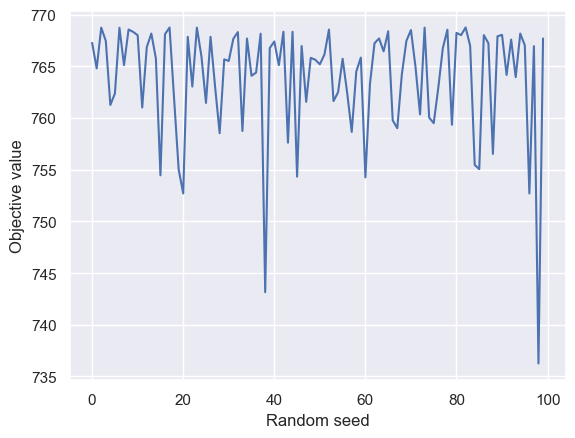

In [100]:
rand_obj = np.nan * np.ones(100)
for seed in range(rand_obj.shape[0]):
    y_rand = get_random_assignment(random_state=seed)
    rand_obj[seed] = objective(X, y_rand)
    #print('Seed = %2d, Objective = %g' % (seed, obj))
plt.plot(rand_obj) 
plt.xlabel('Random seed')
plt.ylabel('Objective value')
#plt.scatter(X[:, 0], X[:, 1], c=y_rand, s=50, cmap='viridis')

# How many possible assignments are there?

In terms of the number of samples $n$ and the number of communities $k$

In [101]:
n_samples = X.shape[0]
n_communities = 2
n_assignments = n_communities ** (n_samples-1)
print('For %d samples and %d communities, there are %d possible assignments' 
      % (n_samples, n_communities, n_assignments))
print('Or in exponential notation: %g possible assignments' % n_assignments)

For 200 samples and 2 communities, there are 803469022129495137770981046170581301261101496891396417650688 possible assignments
Or in exponential notation: 8.03469e+59 possible assignments


## Some perspective: Fastest super computer is 200 petaflops = 2 * 10^17 operations per second

In [102]:
ops = 2 * (10 ** 17)
print(ops)
compute_time = n_assignments / ops
compute_time_years = compute_time / 60 / 60 / 24 / 365
print('Years of compute time: %d' % compute_time_years)

200000000000000000
Years of compute time: 127389177785625178899305200808361984


# Clearly, not a good way to optimize 

# Consider an **equivalent** optimization via community *representatives*

- Intuition: Instead of measuring from each person to every other person in the same community, measure between a person and an ideal "representative" of each community, who is at the center of everyone.
- Representative can move freely.
- If the community assignments $\mathcal{C}_j$ are fixed, then the position of the "representative", denoted by $\mu_j$ is defines as the mean/average point:
$$\mu_j \equiv \frac{1}{|\mathcal{C}_j|} \sum_{x \in \mathcal{C}_j} x_i $$
- Given this definition of the representative, this leads to the following equivalent minimization:
$$ \arg \min_{\mathcal{C}_1, \mathcal{C}_2, \dots, \mathcal{C}_k} \sum_{j=1}^k \sum_{x \in \mathcal{C}_j} \text{dist}(x, \mu_j)^2 $$
$$ \arg \min_{\mathcal{C}_1, \mathcal{C}_2, \dots, \mathcal{C}_k} \sum_{j=1}^k \sum_{x \in \mathcal{C}_j} \text{dist}\left(x, \frac{1}{|\mathcal{C}_j|} \sum_{x \in \mathcal{C}_j} x_i\right)^2 $$

(Derivation of equivalence can be seen at  https://www.math.ucdavis.edu/~strohmer/courses/180BigData/180lecture_kmeans.pdf )

# Implement the objective of the equivalent optimization 

$$ \arg \min_{\mathcal{C}_1, \mathcal{C}_2, \dots, \mathcal{C}_k} \sum_{j=1}^k \sum_{x \in \mathcal{C}_j} \text{dist}(x, \mu_j)^2 $$

In [103]:
def objective2(X, y):
    k = len(np.unique(y))
    out = 0
    for j in range(k):
        sel = (y==j)  # boolean array
        Xj = X[sel, :]
        mu_j = np.mean(Xj, axis=0)
        dist_to_mu = np.sqrt(np.sum((Xj - mu_j)**2, axis=0))
        out += np.sum(dist_to_mu**2)
    return out

print('Quick sanity check that objective corresponds to visual understanding')
print('Objective random', objective2(X, y_rand))
print('Objective visual', objective2(X, y_true))

Quick sanity check that objective corresponds to visual understanding
Objective random 767.6798998712537
Objective visual 94.67363954089788


# Let's suppose the representative can move around and the communities haven't settled yet

Lets implement the following objective
$$ \arg \min_{\mathcal{C}_1, \dots, \mathcal{C}_k\\ \mu_1, \dots, \mu_k} \sum_{j=1}^k \sum_{x \in \mathcal{C}_j} \text{dist}(x, \mu_j)^2 $$


In [104]:
def objective3(X, y, mu_array):
    k = len(np.unique(y))
    out = 0
    for j in range(k):
        sel = (y==j)  # boolean array
        Xj = X[sel, :]
        mu_j = mu_array[j, :]
        dist_to_mu = np.sqrt(np.sum((Xj - mu_j)**2, axis=0))
        out += np.sum(dist_to_mu**2)
    return out

# Two intuitive ideas in this "unsettled" state

1. People will join the community of their closest *representative* $\mu_j$.
$$ y_i = \arg\min_{j=\{1, 2, \dots, k\}} \text{dist}(x_i, \mu_j) $$

2. The representative will move to the center of it's current community.
$$\mu_j = \frac{1}{|\mathcal{C}_j|} \sum_{x \in \mathcal{C}_j} x_i $$

# Let's assume the representatives don't know anything about the community so they just randomly choose to start in one house

# (1) Assign people to their communities based on the representatives

In [105]:
mu_array = np.array([[0, 1], [1, 0]])
print(objective3(X, y_rand, mu_array))

# Assign people
def best_assignment(X, mu_array):
    y_best = np.argmin(pairwise_distances(X, mu_array), axis=1)
    return y_best

y_new = best_assignment(X, mu_array)
print(objective3(X, y_new, mu_array))

1962.9925399178157
1482.1076321431726


# Make simple function for plotting (use ax as argument)

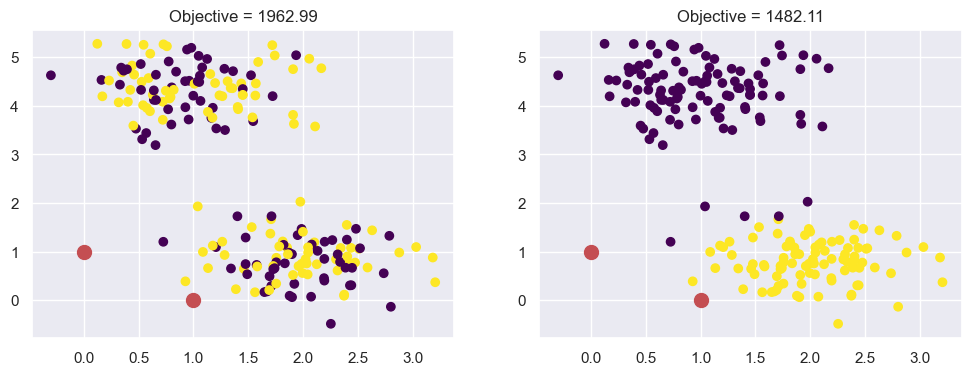

In [106]:
def plot_clustering(X, y, mu_array, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(mu_array[:, 0], mu_array[:, 1], 'ro', markersize=10)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    ax.set_title('Objective = %g' % objective3(X, y, mu_array))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ycur, ax in zip([y_rand, y_new], axes):
    plot_clustering(X, ycur, mu_array, ax=ax)

# (2) Now let's move the representative to the center of its community

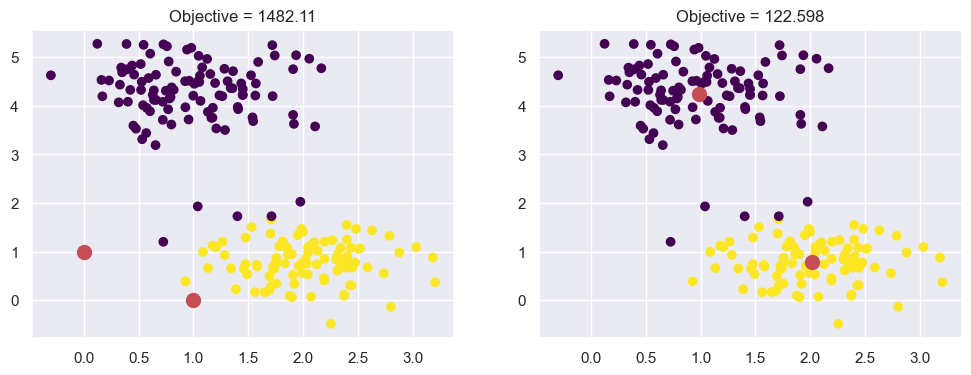

In [107]:
def recenter(X, y):
    return np.array([
        np.mean(X[y==yv, :], axis=0)
        for yv in np.unique(y)
    ])
mu_array_new = recenter(X, y_new)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for m, ax in zip([mu_array, mu_array_new], axes):
    plot_clustering(X, y_new, m, ax=ax)

# What do you think you should do next?

Alternate between the two steps! Which gives you the k-means algorithm.

In [108]:
# Program kmeans
def kmeans_alg(X, maxiter=100, random_state=None):
    rng = check_random_state(random_state)
    
    # Initialize with random points in X
    rand_idx = rng.permutation(X.shape[0])
    mu_array = X[rand_idx[:2], :]
    y = get_random_assignment(random_state=rng)
    
    for i in range(maxiter):
        # Get new best assignment
        y_old = y  # Save old assignment matrix
        y = best_assignment(X, mu_array)

        # Recenter / compute cluster mean
        mu_array = recenter(X, y)

        # Check convergence
        if y_old is not None and np.all(y == y_old):
            print('Converged after %d iteration' % i)
            break
    return y, mu_array

Text(0.5, 1.0, 'Objective = 94.6736')

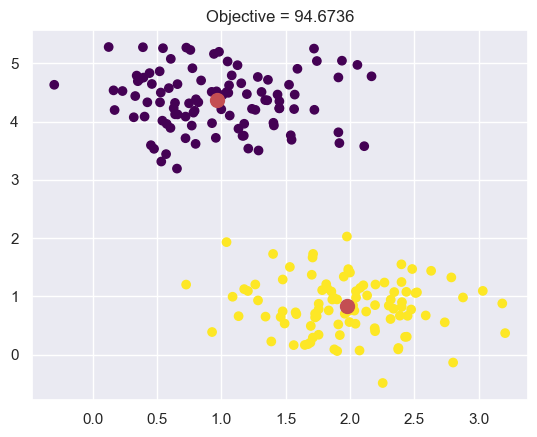

In [109]:
y_kmeans, mu_kmeans = kmeans_alg(X, maxiter=3, random_state=0)

plt.plot(mu_kmeans[:, 0], mu_kmeans[:, 1], 'ro', markersize=10)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis')
plt.title('Objective = %g' % objective3(X, y_kmeans, mu_kmeans))

# Let's inspect the underlying operation by splitting the iteration

In [110]:
# Program kmeans
def kmeans_alg(X, maxiter=100, random_state=None):
    rng = check_random_state(random_state)
    
    # Initialize with random points in X
    rand_idx = rng.permutation(X.shape[0])
    mu_array = X[rand_idx[:2], :]
    y = get_random_assignment(random_state=rng)
    
    for i in range(int(2*maxiter)): #CHANGED
        if i % 2 == 0: #CHANGED
            # Get new best assignment
            y_old = y  # Save old assignment matrix
            y = best_assignment(X, mu_array)
        else: #CHANGED
            # Recenter / compute cluster mean
            mu_array = recenter(X, y)

            # Check convergence
            if y_old is not None and np.all(y == y_old):
                print('Converged after %d iteration' % (i/2)) #CHANGED
                break
    return y, mu_array

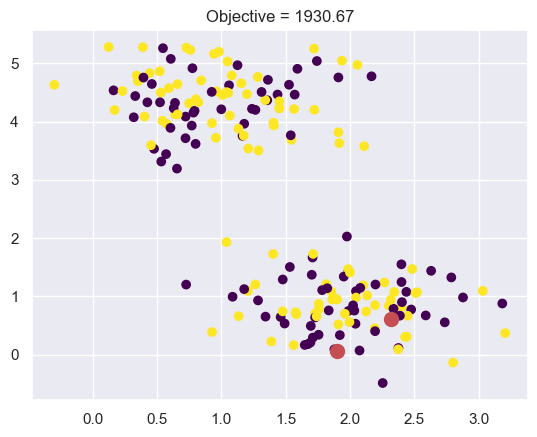

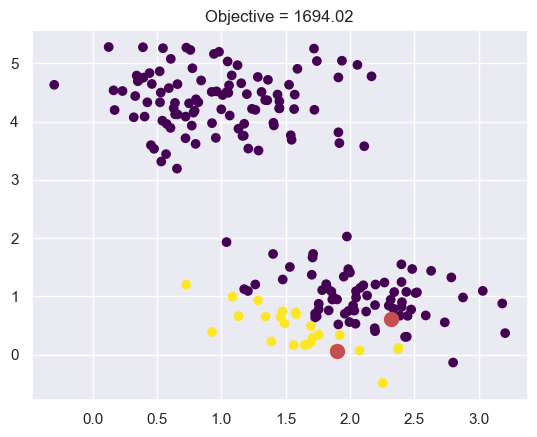

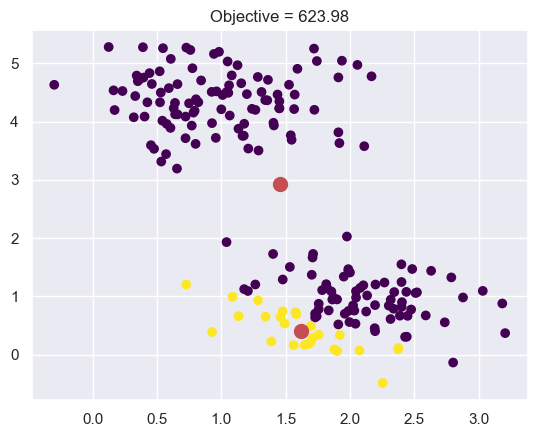

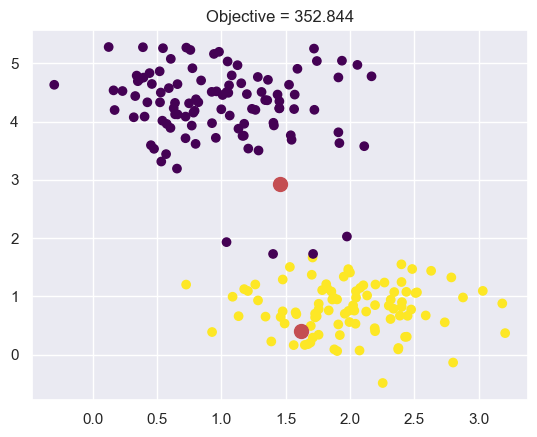

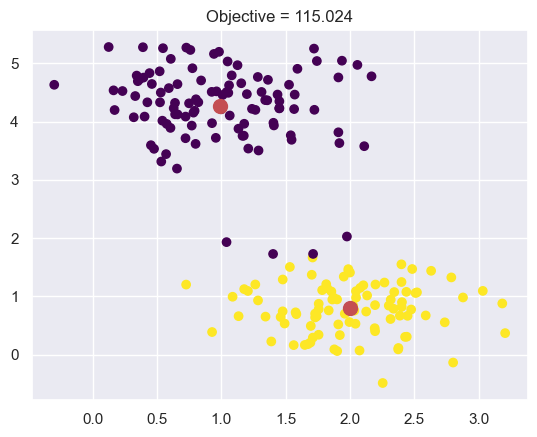

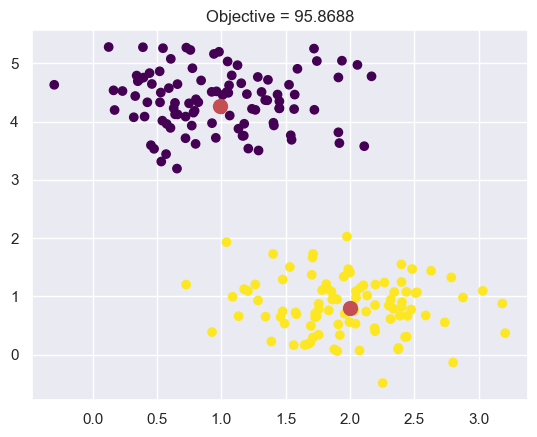

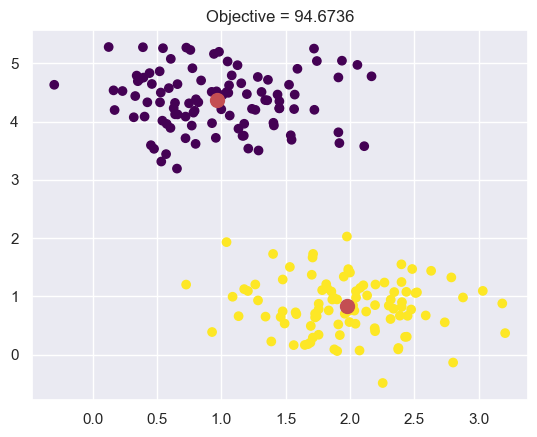

In [111]:
for maxiter in [0, 0.5, 1, 1.5, 2, 2.5, 3]:
  y_kmeans, mu_kmeans = kmeans_alg(X, maxiter=maxiter, random_state=0)

  plt.plot(mu_kmeans[:, 0], mu_kmeans[:, 1], 'ro', markersize=10)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis')
  plt.title('Objective = %g' % objective3(X, y_kmeans, mu_kmeans))
  plt.show()

# Introducing scikit-learn's `sklearn.cluster.KMeans`

- Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html (some nice examples at the bottom of the documentation)
- See Python handbook for nice examples of kmeans https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

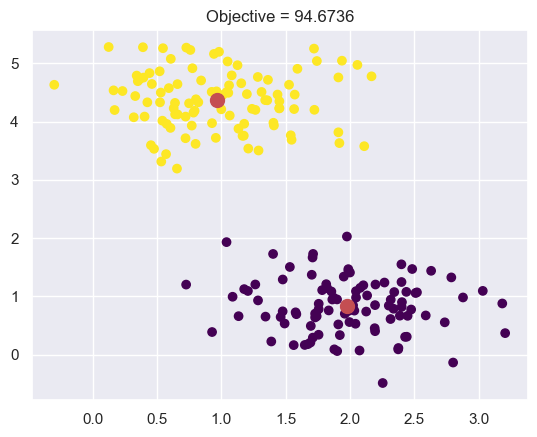

In [112]:
X, y_true = make_blobs(n_samples=200, centers=2,
                       cluster_std=0.50, random_state=0)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=2) # 0 and 2 give opposite clusterings

kmeans.fit(X)
y_kmeans = kmeans.labels_
mu_array = kmeans.cluster_centers_
plot_clustering(X, y_kmeans, mu_array)

# This looks great!  But isn't this an NP-Hard problem?

# First caveat: Does not always converge to the optimal/best solution.

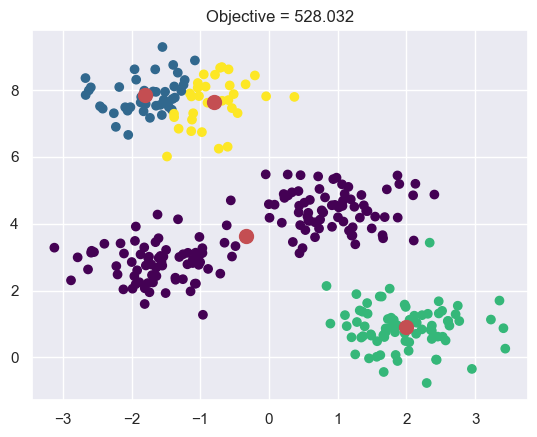

In [113]:
# Example from Python handbook
X2, y_true2 = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

kmeans = KMeans(n_clusters=4, init='random', n_init=1, random_state=104) # 104 gives bad seeding
kmeans.fit(X2)
plot_clustering(X2, kmeans.labels_, kmeans.cluster_centers_)

# Second caveat: Choosing the number of clusters is not obvious

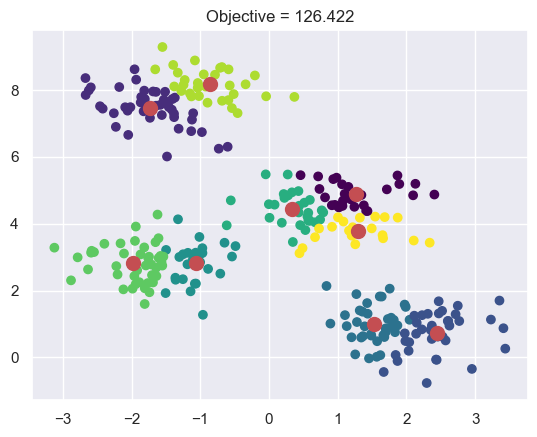

In [114]:
# Example from Python handbook
X2, y_true2 = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

kmeans = KMeans(n_clusters=9, init='random', n_init=1, random_state=0)
kmeans.fit(X2)
plot_clustering(X2, kmeans.labels_, kmeans.cluster_centers_)

# Third caveat: Scaling of variables matters

(np.float64(-7.66950099150201),
 np.float64(38.844282411672744),
 np.float64(-1.2536474338023187),
 np.float64(5.866108305124282))

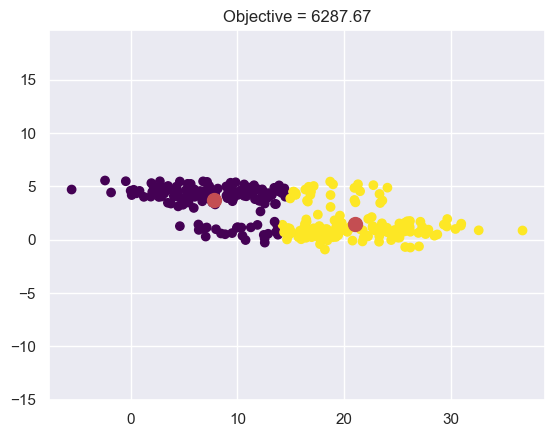

In [115]:
X3, y_true = make_blobs(n_samples=300, centers=2,
                       cluster_std=0.60, random_state=0)
X3[:, 0] = X3[:, 0]*10

kmeans = KMeans(n_clusters=2, random_state=0).fit(X3)

plot_clustering(X3, kmeans.labels_, kmeans.cluster_centers_)
plt.axis('equal')

# Fourth caveat: Scaling of clusters matters

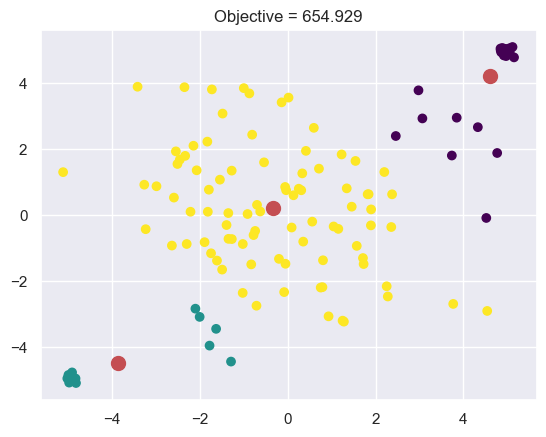

In [116]:
X4, y_true4 = make_blobs(n_samples=[10, 100, 20], centers=[(-5, -5), (0, 0), (5, 5)], 
                         cluster_std=[0.1, 2, 0.1], random_state=0)

# sensitive to outliers
# X4, y_true4 = make_blobs(n_samples=[1, 100, 100], centers=[(-5, -5), (0, 0), (5, 5)], 
                         # cluster_std=[1, 1, 1], random_state=0)

kmeans = KMeans(n_clusters=3, init='random', n_init=1, random_state=0).fit(X4)
plot_clustering(X4, kmeans.labels_, kmeans.cluster_centers_)

# Fifth caveat: Only linear boundaries between clusters

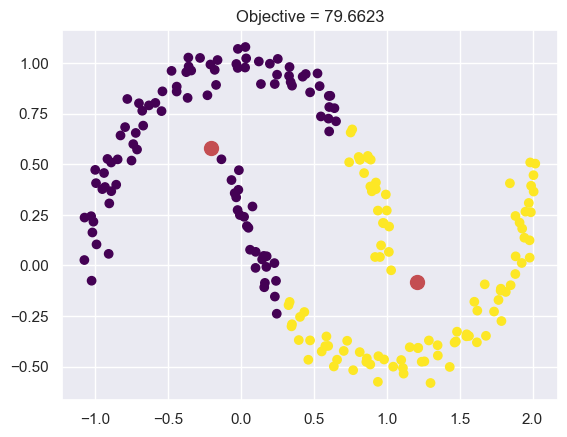

In [117]:
from sklearn.datasets import make_moons
X5, y_true5 = make_moons(200, noise=.05, random_state=0)

kmeans = KMeans(n_clusters=2, random_state=0).fit(X5)
plot_clustering(X5, kmeans.labels_, kmeans.cluster_centers_)